PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs
1
DEBUG:tensorflow:Layer GRU_W2V will use cuDNN kernels when running on GPU.
Epoch 1/50
32/32 [==============================] - 6s 158ms/step - loss: 0.6144 - accuracy: 0.6597 - val_loss: 0.5410 - val_accuracy: 0.7289
Epoch 2/50
32/32 [==============================] - 5s 159ms/step - loss: 0.5464 - accuracy: 0.7300 - val_loss: 0.4954 - val_accuracy: 0.7600
Epoch 3/50
32/32 [==============================] - 5s 160ms/step - loss: 0.4195 - accuracy: 0.8314 - val_loss: 0.4710 - val_accuracy: 0.8267
Epoch 4/50
32/32 [==============================] - 8s 246ms/step - loss: 0.3180 - accuracy: 0.8956 - val_loss: 0.2407 - val_accuracy: 0.9244
Epoch 5/50
32/32 [==============================] - 10s 310ms/step - loss: 0.2383 - accuracy: 0.9253 - val_loss: 0.2309 - val_accuracy: 0.9289
Epoch 6/50
32/32 [==============================] - 11s 339ms/step - loss: 0.2499 - accuracy: 0.9219 - val_loss: 0.

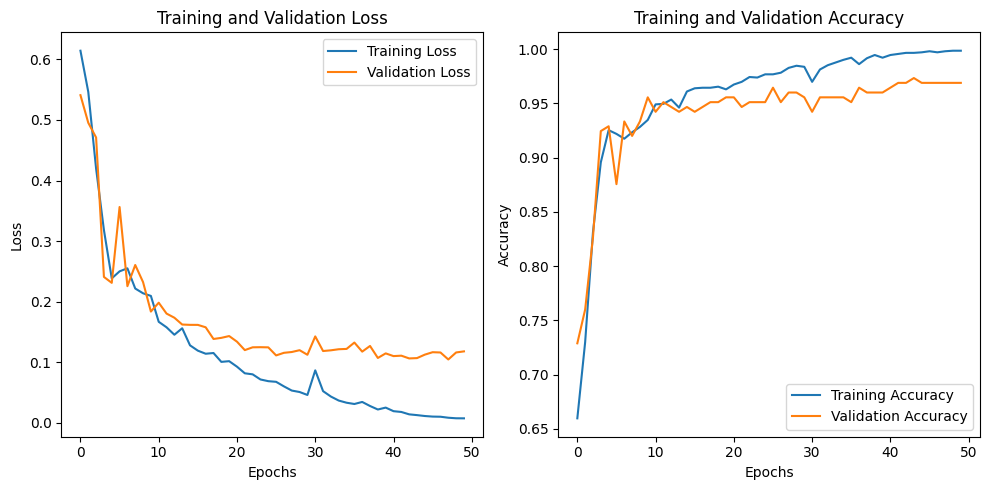

31/31 [==============================] - 3s 108ms/step
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       462
           1       0.97      0.97      0.97       501

    accuracy                           0.97       963
   macro avg       0.97      0.97      0.97       963
weighted avg       0.97      0.97      0.97       963

Confusion Matrix:
[[446  16]
 [ 17 484]]
44/44 [==============================] - 4s 93ms/step
DEBUG:tensorflow:Layer GRU_W2V will use cuDNN kernels when running on GPU.
Epoch 1/50
32/32 [==============================] - 10s 314ms/step - loss: 0.5944 - accuracy: 0.6879 - val_loss: 0.5352 - val_accuracy: 0.7289
Epoch 2/50
32/32 [==============================] - 11s 323ms/step - loss: 0.5018 - accuracy: 0.7695 - val_loss: 0.4537 - val_accuracy: 0.8089
Epoch 3/50
32/32 [==============================] - 10s 323ms/step - loss: 0.2835 - accuracy: 0.8961 - val_loss: 0.2265 - val_accuracy: 0.9378
Epoch 4/50
32/32 [=

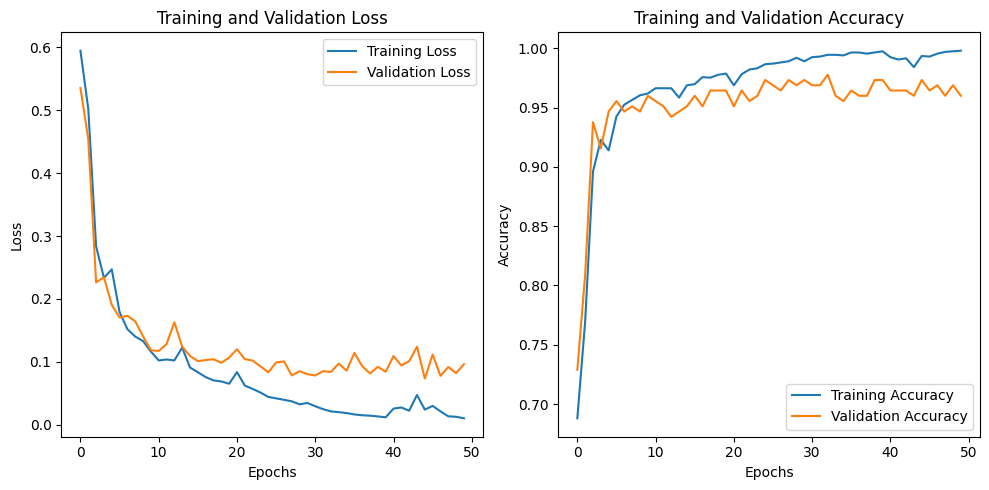

31/31 [==============================] - 1s 27ms/step
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       462
           1       0.99      0.96      0.97       501

    accuracy                           0.97       963
   macro avg       0.97      0.97      0.97       963
weighted avg       0.97      0.97      0.97       963

Confusion Matrix:
[[455   7]
 [ 21 480]]
44/44 [==============================] - 1s 27ms/step
DEBUG:tensorflow:Layer GRU_W2V will use cuDNN kernels when running on GPU.
Epoch 1/50
32/32 [==============================] - 3s 93ms/step - loss: 0.5973 - accuracy: 0.6771 - val_loss: 0.5348 - val_accuracy: 0.7111
Epoch 2/50
32/32 [==============================] - 3s 92ms/step - loss: 0.5177 - accuracy: 0.7453 - val_loss: 0.5049 - val_accuracy: 0.7778
Epoch 3/50
32/32 [==============================] - 3s 92ms/step - loss: 0.3842 - accuracy: 0.8393 - val_loss: 0.3371 - val_accuracy: 0.8622
Epoch 4/50
32/32 [========

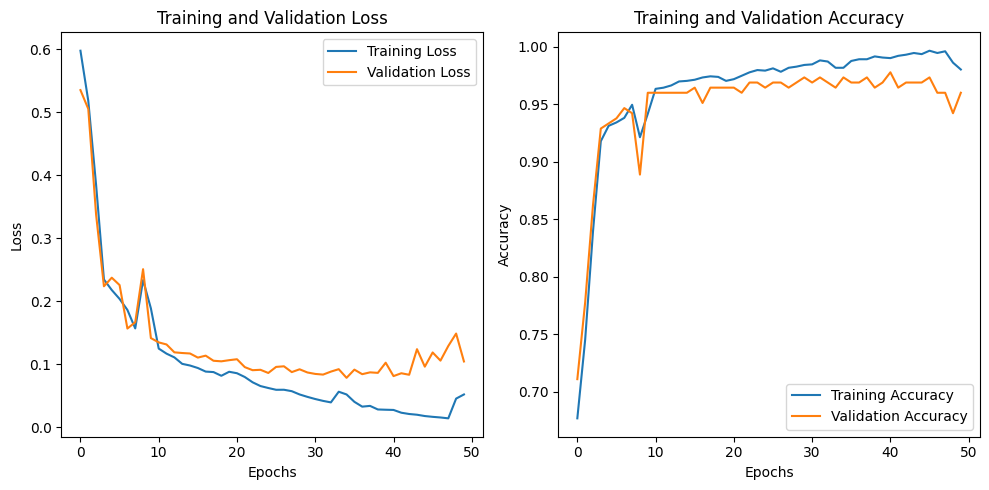

31/31 [==============================] - 1s 27ms/step
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       462
           1       0.97      0.95      0.96       501

    accuracy                           0.96       963
   macro avg       0.96      0.96      0.96       963
weighted avg       0.96      0.96      0.96       963

Confusion Matrix:
[[449  13]
 [ 24 477]]
44/44 [==============================] - 1s 28ms/step


In [1]:
import os
# os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score

os.environ['TF_FORCE_UNIFIED_MEMORY']='1'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='2.0'
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH ']='true' # as I understood, this is redundant with the set_memory_growth part :)

import tensorflow as tf    
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      print(gpu)
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


tf.data.experimental.enable_debug_mode()
tf.config.run_functions_eagerly(True)
tf.get_logger().setLevel(tf.compat.v1.logging.DEBUG)
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Embedding, GRU, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import keras.backend as K
from keras.optimizers import Adam

import pickle
from gensim.models import Word2Vec

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val


# Function to load files from a directory
def load_files(directory):
    file_list = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".c"):
                file_path = os.path.join(root, file)
                with open(file_path, "r") as file_content:
                    file_text = file_content.read()
                file_list.append(file_text)
    return file_list
# Load training and test files for vulnerable and non-vulnerable classes
def load_data():
    dataset_dir = 'F://Development_//Deep Learning//Basic Dataset//BTP//1//Dataset//Raw//dataset 1//Dataset_raw'
    vulnerable_dir = os.path.join(dataset_dir, 'Vulnerable')
    non_vulnerable_dir = os.path.join(dataset_dir, 'Non_vulnerable')

    vulnerable_train_files = load_files(os.path.join(vulnerable_dir, 'TRAIN'))
    vulnerable_test_files = load_files(os.path.join(vulnerable_dir, 'TEST'))
    non_vulnerable_train_files = load_files(os.path.join(non_vulnerable_dir, 'TRAIN'))
    non_vulnerable_test_files = load_files(os.path.join(non_vulnerable_dir, 'TEST'))

    train_codes = vulnerable_train_files + non_vulnerable_train_files
    test_codes = vulnerable_test_files + non_vulnerable_test_files

    labels = np.concatenate((np.ones(len(vulnerable_train_files)), np.zeros(len(non_vulnerable_train_files))), axis=0)

    X_train, X_test, y_train, y_test = train_test_split(train_codes, labels, test_size=0.3, random_state=42)

    return X_train, X_test, y_train, y_test, test_codes


def tokenize_sequences(X_train, X_test, test_codes):
    tokenizer = Tokenizer(num_words=539249, split=' ')
    tokenizer.fit_on_texts(X_train)
    X_train_sequences = tokenizer.texts_to_sequences(X_train)
    X_test_sequences = tokenizer.texts_to_sequences(X_test)
    test_sequences = tokenizer.texts_to_sequences(test_codes)

    average_sequence_length = int(np.mean([len(seq) for seq in X_train_sequences]))

    X_train_padded = pad_sequences(X_train_sequences, maxlen=average_sequence_length)
    X_test_padded = pad_sequences(X_test_sequences, maxlen=average_sequence_length)
    test_padded = pad_sequences(test_sequences, maxlen=average_sequence_length)

    return X_train_padded, X_test_padded, test_padded, tokenizer.word_index


def load_embedding_model(x):
  filename = f'F://Development_//Deep Learning//Basic Dataset//BTP//1//Outputs//Embedding Models 2//Word2vec//word2vec_{x}_model.pkl'

  with open(filename, 'rb') as f:
    embedding_model = pickle.load(f)

  return embedding_model

def create_model(vocab_size, embedding_dim, embedding_matrix, max_sequence_length):
    # Create an Adam optimizer with the desired learning rate
    adam_optimizer = Adam(learning_rate=0.001)
    
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False, name='GRU_W2V_EL'))
    model.add(GRU(units=100, name='GRU_W2V'))
    model.add(Dense(units=2, activation='softmax', name='GRU_W2V_OL'))    
    # Compile the model with the custom optimizer
    model.compile(loss='binary_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])
    
    return model


def evaluate_model(X_test_padded, y_test, model):
    y_pred_prob = model.predict(X_test_padded)  

    y_pred = np.argmax(y_pred_prob, axis=1)

    if y_test.shape[1] > 1:
        y_test = np.argmax(y_test, axis=1)

    report = classification_report(y_test, y_pred)
    print(report)

    confusion = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(confusion)


def predict_additional_data(test_padded, model):
    test_pred_prob = model.predict(test_padded)
    test_pred = (test_pred_prob > 0.5).astype(int)
    return test_pred


def save_model(model, fold):
    model.save(f"F://Development_//Deep Learning//Basic Dataset//BTP//1//Outputs//Checkpoints//Sentence//LSTM//Word2vec//model10k_fold_{fold}.h5")


# Load the data
X_train, X_test, y_train, y_test, test_codes = load_data()
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)

# Tokenize the sequences
X_train_padded, X_test_padded, test_padded, word_index = tokenize_sequences(X_train, X_test, test_codes)
print("1")
# Load the Word2Vec embedding model

embedding_dims = [50,100,150]

for embedding_dim in embedding_dims:
    embedding_model = load_embedding_model(embedding_dim)
    
    # Create the embedding matrix
    embedding_dim = embedding_dim
    vocab_size = 539249
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in word_index.items():
        if i < vocab_size and word in embedding_model.wv:
            embedding_matrix[i] = embedding_model.wv[word]
    
    # Create a sequential model
    model = create_model(vocab_size, embedding_dim, embedding_matrix, X_train_padded.shape[1])
    
    X_train_fold, X_val_fold, y_train_fold, y_val_fold = train_test_split(X_train_padded, y_train, test_size=0.1, random_state=42)
      
    
    history = model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=64, validation_data=(X_val_fold, y_val_fold))
    
    # Plot both loss and accuracy
    plt.figure(figsize=(10, 5))  # Adjust figure size as desired
    plt.subplot(1, 2, 1)  # Create subplot for loss
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
        
    plt.subplot(1, 2, 2)  # Create subplot for accuracy
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()
    # Evaluate the model using the test set
    evaluate_model(X_test_padded, y_test, model)
    
    # Predict on the additional test set
    test_pred = predict_additional_data(test_padded, model)        
        
    model.save(f"F://Development_//Deep Learning//Basic Dataset//BTP//1//Outputs//Models//LSTM//word2vec/GRU_w2v_{embedding_dim}.keras")
    

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs
1
DEBUG:tensorflow:Layer GRU_W2V will use cuDNN kernels when running on GPU.
Epoch 1/50
32/32 [==============================] - 3s 87ms/step - loss: 0.5629 - accuracy: 0.7161 - val_loss: 0.4905 - val_accuracy: 0.7689
Epoch 2/50
32/32 [==============================] - 3s 86ms/step - loss: 0.4327 - accuracy: 0.8091 - val_loss: 0.4456 - val_accuracy: 0.7867
Epoch 3/50
32/32 [==============================] - 3s 86ms/step - loss: 0.3442 - accuracy: 0.8487 - val_loss: 0.3605 - val_accuracy: 0.8622
Epoch 4/50
32/32 [==============================] - 3s 86ms/step - loss: 0.2458 - accuracy: 0.9105 - val_loss: 0.1998 - val_accuracy: 0.9422
Epoch 5/50
32/32 [==============================] - 3s 86ms/step - loss: 0.1591 - accuracy: 0.9520 - val_loss: 0.1460 - val_accuracy: 0.9600
Epoch 6/50
32/32 [==============================] - 3s 86ms/step - loss: 0.1097 - accuracy: 0.9688 - val_loss: 0.1246 - v

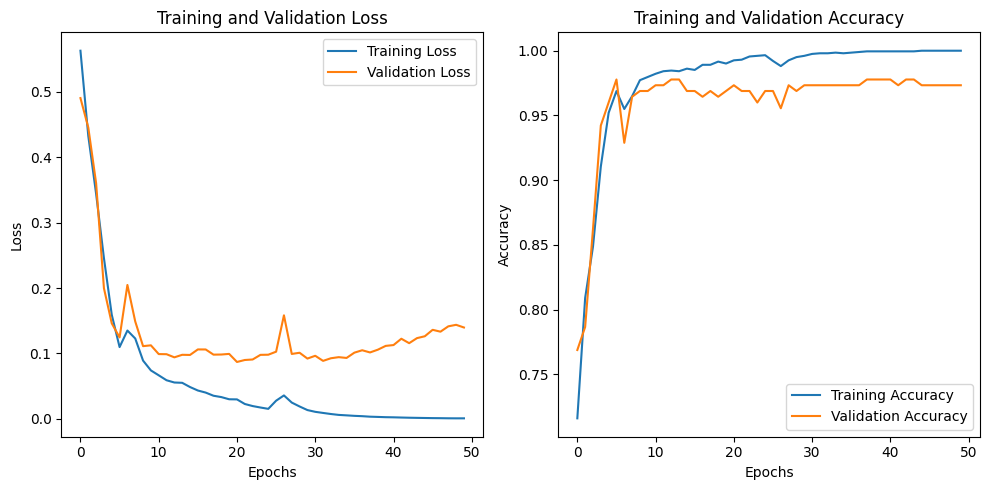

31/31 [==============================] - 1s 27ms/step
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       462
           1       0.97      0.97      0.97       501

    accuracy                           0.97       963
   macro avg       0.97      0.97      0.97       963
weighted avg       0.97      0.97      0.97       963

Confusion Matrix:
[[449  13]
 [ 15 486]]
44/44 [==============================] - 1s 27ms/step
DEBUG:tensorflow:Layer GRU_W2V will use cuDNN kernels when running on GPU.
Epoch 1/50
32/32 [==============================] - 3s 91ms/step - loss: 0.5777 - accuracy: 0.6899 - val_loss: 0.5013 - val_accuracy: 0.7733
Epoch 2/50
32/32 [==============================] - 3s 90ms/step - loss: 0.4198 - accuracy: 0.8155 - val_loss: 0.4220 - val_accuracy: 0.8089
Epoch 3/50
32/32 [==============================] - 3s 90ms/step - loss: 0.3134 - accuracy: 0.8749 - val_loss: 0.2794 - val_accuracy: 0.8711
Epoch 4/50
32/32 [========

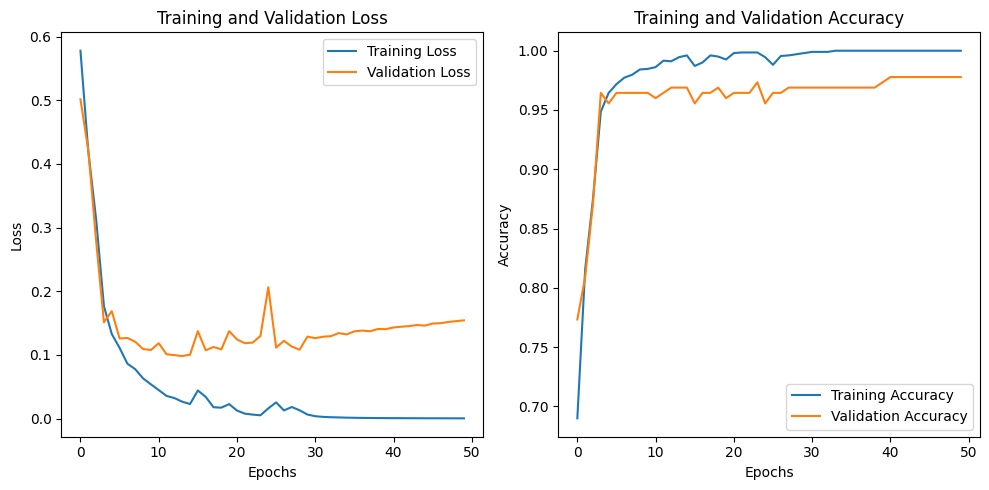

31/31 [==============================] - 1s 28ms/step
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       462
           1       0.97      0.97      0.97       501

    accuracy                           0.96       963
   macro avg       0.96      0.96      0.96       963
weighted avg       0.96      0.96      0.96       963

Confusion Matrix:
[[445  17]
 [ 17 484]]
44/44 [==============================] - 1s 28ms/step
DEBUG:tensorflow:Layer GRU_W2V will use cuDNN kernels when running on GPU.
Epoch 1/50
32/32 [==============================] - 3s 97ms/step - loss: 0.5630 - accuracy: 0.7211 - val_loss: 0.5004 - val_accuracy: 0.7778
Epoch 2/50
32/32 [==============================] - 3s 96ms/step - loss: 0.4351 - accuracy: 0.8066 - val_loss: 0.4199 - val_accuracy: 0.8044
Epoch 3/50
32/32 [==============================] - 3s 97ms/step - loss: 0.3266 - accuracy: 0.8670 - val_loss: 0.3183 - val_accuracy: 0.8622
Epoch 4/50
32/32 [========

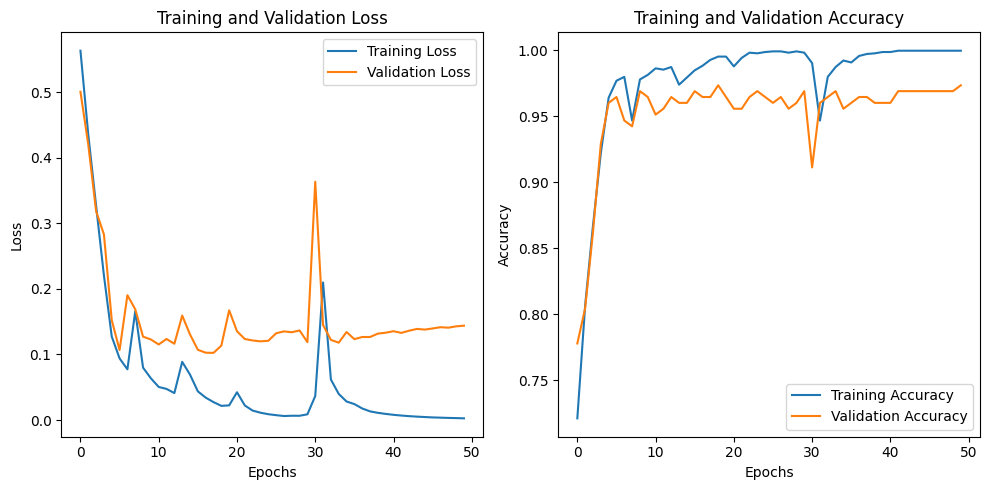

31/31 [==============================] - 1s 28ms/step
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       462
           1       0.97      0.97      0.97       501

    accuracy                           0.97       963
   macro avg       0.97      0.97      0.97       963
weighted avg       0.97      0.97      0.97       963

Confusion Matrix:
[[446  16]
 [ 14 487]]
44/44 [==============================] - 1s 29ms/step


In [2]:
import os
# os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score

os.environ['TF_FORCE_UNIFIED_MEMORY']='1'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='2.0'
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH ']='true' # as I understood, this is redundant with the set_memory_growth part :)

import tensorflow as tf    
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      print(gpu)
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


tf.data.experimental.enable_debug_mode()
tf.config.run_functions_eagerly(True)
tf.get_logger().setLevel(tf.compat.v1.logging.DEBUG)
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Embedding, GRU, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import keras.backend as K
from keras.optimizers import Adam

import pickle
from gensim.models import Word2Vec

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val


# Function to load files from a directory
def load_files(directory):
    file_list = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".c"):
                file_path = os.path.join(root, file)
                with open(file_path, "r") as file_content:
                    file_text = file_content.read()
                file_list.append(file_text)
    return file_list
# Load training and test files for vulnerable and non-vulnerable classes
def load_data():
    dataset_dir = 'F://Development_//Deep Learning//Basic Dataset//BTP//1//Dataset//Raw//dataset 1//Dataset_raw'
    vulnerable_dir = os.path.join(dataset_dir, 'Vulnerable')
    non_vulnerable_dir = os.path.join(dataset_dir, 'Non_vulnerable')

    vulnerable_train_files = load_files(os.path.join(vulnerable_dir, 'TRAIN'))
    vulnerable_test_files = load_files(os.path.join(vulnerable_dir, 'TEST'))
    non_vulnerable_train_files = load_files(os.path.join(non_vulnerable_dir, 'TRAIN'))
    non_vulnerable_test_files = load_files(os.path.join(non_vulnerable_dir, 'TEST'))

    train_codes = vulnerable_train_files + non_vulnerable_train_files
    test_codes = vulnerable_test_files + non_vulnerable_test_files

    labels = np.concatenate((np.ones(len(vulnerable_train_files)), np.zeros(len(non_vulnerable_train_files))), axis=0)

    X_train, X_test, y_train, y_test = train_test_split(train_codes, labels, test_size=0.3, random_state=42)

    return X_train, X_test, y_train, y_test, test_codes


def tokenize_sequences(X_train, X_test, test_codes):
    tokenizer = Tokenizer(num_words=539249, split=' ')
    tokenizer.fit_on_texts(X_train)
    X_train_sequences = tokenizer.texts_to_sequences(X_train)
    X_test_sequences = tokenizer.texts_to_sequences(X_test)
    test_sequences = tokenizer.texts_to_sequences(test_codes)

    average_sequence_length = int(np.mean([len(seq) for seq in X_train_sequences]))

    X_train_padded = pad_sequences(X_train_sequences, maxlen=average_sequence_length)
    X_test_padded = pad_sequences(X_test_sequences, maxlen=average_sequence_length)
    test_padded = pad_sequences(test_sequences, maxlen=average_sequence_length)

    return X_train_padded, X_test_padded, test_padded, tokenizer.word_index


def load_embedding_model(x):
  filename = f'F://Development_//Deep Learning//Basic Dataset//BTP//1//Outputs//Embedding Models 2//FastText//fasttext_{x}_model.pkl'

  with open(filename, 'rb') as f:
    embedding_model = pickle.load(f)

  return embedding_model

def create_model(vocab_size, embedding_dim, embedding_matrix, max_sequence_length):
    # Create an Adam optimizer with the desired learning rate
    adam_optimizer = Adam(learning_rate=0.001)
    
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False, name='GRU_W2V_EL'))
    model.add(GRU(units=100, name='GRU_W2V'))
    model.add(Dense(units=2, activation='softmax', name='GRU_W2V_OL'))    
    # Compile the model with the custom optimizer
    model.compile(loss='binary_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])
    
    return model


def evaluate_model(X_test_padded, y_test, model):
    y_pred_prob = model.predict(X_test_padded)  

    y_pred = np.argmax(y_pred_prob, axis=1)

    if y_test.shape[1] > 1:
        y_test = np.argmax(y_test, axis=1)

    report = classification_report(y_test, y_pred)
    print(report)

    confusion = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(confusion)


def predict_additional_data(test_padded, model):
    test_pred_prob = model.predict(test_padded)
    test_pred = (test_pred_prob > 0.5).astype(int)
    return test_pred


def save_model(model, fold):
    model.save(f"F://Development_//Deep Learning//Basic Dataset//BTP//1//Outputs//Checkpoints//Sentence//LSTM//Word2vec//model10k_fold_{fold}.h5")


# Load the data
X_train, X_test, y_train, y_test, test_codes = load_data()
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)

# Tokenize the sequences
X_train_padded, X_test_padded, test_padded, word_index = tokenize_sequences(X_train, X_test, test_codes)
print("1")
# Load the Word2Vec embedding model

embedding_dims = [50,100,150]

for embedding_dim in embedding_dims:
    embedding_model = load_embedding_model(embedding_dim)
    
    # Create the embedding matrix
    embedding_dim = embedding_dim
    vocab_size = 539249
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in word_index.items():
        if i < vocab_size and word in embedding_model.wv:
            embedding_matrix[i] = embedding_model.wv[word]
    
    # Create a sequential model
    model = create_model(vocab_size, embedding_dim, embedding_matrix, X_train_padded.shape[1])
    
    X_train_fold, X_val_fold, y_train_fold, y_val_fold = train_test_split(X_train_padded, y_train, test_size=0.1, random_state=42)
      
    
    history = model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=64, validation_data=(X_val_fold, y_val_fold))
    
    # Plot both loss and accuracy
    plt.figure(figsize=(10, 5))  # Adjust figure size as desired
    plt.subplot(1, 2, 1)  # Create subplot for loss
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
        
    plt.subplot(1, 2, 2)  # Create subplot for accuracy
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()
    # Evaluate the model using the test set
    evaluate_model(X_test_padded, y_test, model)
    
    # Predict on the additional test set
    test_pred = predict_additional_data(test_padded, model)        
        
    model.save(f"F://Development_//Deep Learning//Basic Dataset//BTP//1//Outputs//Models//LSTM//word2vec/GRU_ft_{embedding_dim}.keras")
    